In [0]:
import random
import numpy as np 
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

#### I did this lab on Google Colab, Use the below link for file

[Drive Link](https://drive.google.com/open?id=1s5TFr3hrTHNe8a2P68Y6MWWRj_XzgqE2)

In [0]:
#Run this only if you are using Google Colab
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
Path to my file "/content/drive/My Drive/Colab Notebooks/Day4-CNNs/Exercise"

'/content/drive/My Drive/Colab Notebooks/Day4-CNNs/Exercise'

In [0]:
def load_split(split):
  X_path = '/content/drive/My Drive/Colab Notebooks/Day4-CNNs/Exercise/stl10_binary/{}_X.bin'.format(split)
  y_path = '/content/drive/My Drive/Colab Notebooks/Day4-CNNs/Exercise/stl10_binary/{}_y.bin'.format(split)
  X = np.fromfile(X_path, dtype=np.uint8).reshape((-1, 3, 96, 96))
  X = np.moveaxis(X, 2, 3) # convert column-major to row-major
  y = np.fromfile(y_path, dtype=np.uint8) # data type seems to be important here...
  y = y - 1 #convert range [1,10] to [0,9]
  print('-----------------')
  print('Loaded split "{}" with sizes: Images {}, labels {}'.format(split, X.shape, y.shape))
  return X, y

In [0]:
# ===================
# load the training and test datasets
# ===================
full_train_X, full_train_y = load_split('train')
full_test_X, full_test_y = load_split('test')

-----------------
Loaded split "train" with sizes: Images (5000, 3, 96, 96), labels (5000,)
-----------------
Loaded split "test" with sizes: Images (8000, 3, 96, 96), labels (8000,)


In [0]:
# ===================
# read the names of the classes in the dataset
# ===================
with open('/content/drive/My Drive/Colab Notebooks/Day4-CNNs/Exercise/stl10_binary/class_names.txt') as f:
    full_class_names = f.readlines()

In [0]:
 # ===================
 # strip trailing whitespace
 # ===================
full_class_names = [name.strip() for name in full_class_names]


In [0]:
full_class_names

['airplane',
 'bird',
 'car',
 'cat',
 'deer',
 'dog',
 'horse',
 'monkey',
 'ship',
 'truck']

In [0]:
# ===================
# print the list of names of all classes
# ===================
print('-----------------')
print('The classes in the dataset are: ')
print(list(enumerate(full_class_names)))

-----------------
The classes in the dataset are: 
[(0, 'airplane'), (1, 'bird'), (2, 'car'), (3, 'cat'), (4, 'deer'), (5, 'dog'), (6, 'horse'), (7, 'monkey'), (8, 'ship'), (9, 'truck')]


In [0]:
# ===========================================================================
# Explore a few samples of the dataset
# (repeat the following cell for different output by pressing Ctrl-Enter on it instead of Shift-Enter)
# ===========================================================================

# ===================
# function to show an example image and its label
# ===================
# inputs:
#    X: image
#    y: label
#    class_names: list of names of all classes so that the class name corresponding to the label can be identified
# outputs:
#    None
# ===================
def visualize_sample(X, y, class_names):
    X_vis = np.moveaxis(X, 0, 2) # convert Channel,Width,Height order to W,H,C
    plt.figure()
    plt.imshow(X_vis, interpolation='nearest')
    plt.axis('off')
    plt.title('Class id={}, Name={}'.format(y, class_names[y]))




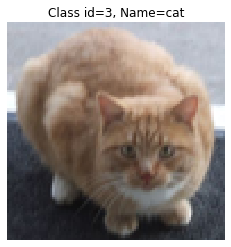

In [0]:
# ===================
# choose a random image and display it 
# you may run this cell multiple times to get an idea of the different images in the dataset
# alternatively, modify the function 'visualize_sample' to display several (4/8/16) different images along with their labels
# ===================
i = random.randint(0, full_train_X.shape[0]-1)
visualize_sample(full_train_X[i],
                 full_train_y[i],
                 full_class_names)

In [0]:
# ===========================================================================
# First, let us train a 2-class classifier.
# ===========================================================================

# ===================
# Let's select from the dataset only samples of classes 'cat' and 'ship'.
# We have arbitrarily chosen these two classes.
# You may try some other pair of classes if you wish to.
# ===================
ID_C1_OLD, ID_C2_OLD = 3, 8 # C1: CAT, C2: SHIP
ID_C1_NEW, ID_C2_NEW = 0, 1

In [0]:
# ===================
# function to delete all the classes other than the cat and ship classes
# ===================
# inputs:
#    X: images from all classes
#    y: labels from all classes
#    split: train / test
# outputs:
#    X_out: images from only cats and ships
#    y_out: labels from only cats and ships
# ===================
def subsplit_two_classes(X, y, split):
    
    indices = np.where(np.logical_or(y==ID_C1_OLD, y==ID_C2_OLD))
    X_out = X[indices]
    y_out = y[indices]
    y_out = (y_out == ID_C1_OLD).astype(np.int) * ID_C1_NEW + (y_out == ID_C2_OLD).astype(np.int) * ID_C2_NEW
    print('Created "{}" subsplit with only 2 classes with sizes: Images {}, labels {}'.format(split, X_out.shape, y_out.shape))
    return X_out, y_out

In [0]:
# ===================
# make the training and test datasets so that they contain only the two classes of interest
# ===================
train_two_classes_X, train_two_classes_y = subsplit_two_classes(full_train_X,
                                                                full_train_y,
                                                                'train')

test_two_classes_X, test_two_classes_y = subsplit_two_classes(full_test_X,
                                                              full_test_y,
                                                              'test')

class_names_two_classes = [full_class_names[i] for i in (ID_C1_OLD, ID_C2_OLD)]



Created "train" subsplit with only 2 classes with sizes: Images (1000, 3, 96, 96), labels (1000,)
Created "test" subsplit with only 2 classes with sizes: Images (1600, 3, 96, 96), labels (1600,)


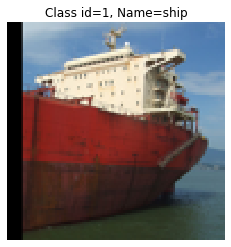

In [0]:
# ===================
# visualize some examples from the modified datasets
# ===================
i = random.randint(0, train_two_classes_X.shape[0]-1)
visualize_sample(train_two_classes_X[i],
                 train_two_classes_y[i],
                 class_names_two_classes)


In [0]:
# ===========================================================================
# Wrap our dataset into pytorch Dataset class so it can further be used in DataLoader for batch grouping
# ===========================================================================
class ArrayDataset(Dataset):
    
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __len__(self):
        return self.X.shape[0]
  
    def __getitem__(self, index):
        return self.X[index], self.y[index]

In [0]:
 # ===================
 # set the batch size here
 # ===================
BATCH_SIZE = 8

# ===================
# load the training and test datasets for the two-class classification problem
# https://pytorch.org/docs/stable/data.html
# ===================
loader_two_classes_train = DataLoader(dataset = ArrayDataset(train_two_classes_X, train_two_classes_y),
                                      batch_size=BATCH_SIZE,
                                      shuffle=True,
                                      drop_last=True)

loader_two_classes_test = DataLoader(dataset = ArrayDataset(test_two_classes_X, test_two_classes_y),
                                     batch_size=1,
                                     shuffle=True)

# ===================
# load the training and test datasets for the ten-class classification problem
# ===================
loader_ten_classes_train = DataLoader(dataset = ArrayDataset(full_train_X, full_train_y),
                                      batch_size=BATCH_SIZE,
                                      shuffle=True,
                                      drop_last=True)

loader_ten_classes_test = DataLoader(dataset = ArrayDataset(full_test_X, full_test_y),
                                     batch_size=1,
                                     shuffle=True)


In [0]:

# ===========================================================================
# Define neural network
# ===========================================================================
class CNN(nn.Module):
  
  # ===================
  # the network architecture is defined here
  # documentation of some useful functions:
  #     https://pytorch.org/docs/stable/nn.html#conv2d
  #     https://pytorch.org/docs/stable/nn.html#batchnorm2d
  #     https://pytorch.org/docs/stable/nn.html#maxpool2d
  #     https://pytorch.org/docs/stable/nn.html#linear
  #     https://pytorch.org/docs/stable/nn.html#batchnorm1d
  # ===================
    def __init__(self, num_out_classes):
    
        super(CNN, self).__init__()
        
        num_filters = [3, 6, 12, 24, 64]
        
        # =======================First Convolution Layer=======================#
        
        # expected size of input to following layer: 3x96x96
        self.conv1 = nn.Conv2d(in_channels=num_filters[0],
                               out_channels=num_filters[1],
                               kernel_size=3,
                               padding=1,
                               bias=False)
        # Expected size of output from Convolution layer : 6x32x32
        
        # Expected size of input to following layer:
        self.bn1 = nn.BatchNorm2d(num_features=num_filters[1])
        # Expected size of output from Batch Normalization : 6x32x32        
        
        # expected size of input to following layer:
        self.relu1 = nn.ReLU()
        # Expected size of output from Activation function: 6x32x32
        
        # expected size of input to following layer:
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        # Expected size of output from Max Pool : 6x16x16
        """
        Kernel size for Max Pool = 2 x 2
        32x32 goes down by 2x2 resulting 16x16 
        """

        # *implement other layers
        
        # =====================Second Convolution Layer========================#

        # Expected size of input to following layer: 6x16x16
        self.conv2 = nn.Conv2d(in_channels=num_filters[1],
                               out_channelts=num_filters[2],
                               kernel_size=3,
                               padding=1,
                               bias=False)
        # Expected size of output from Convolution layer : 12x11x11

        self.bn2 = nn.BatchNorm2d(num_features=num_filters[2])
        # Expected size of output from Batch Normalization : 12x11x11

        self.relu2 = nn.ReLU()
        # Expected size of output from Activation function: 12x11x11
        
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        # Expected size of output from Max Pool : 12x5x5


        # ======================Third Convolution Layer========================#

        # Expected size of input to following layer: 12x5x5
        self.conv3 = nn.Conv2d(in_channels=num_filters[2],
                               out_channelts=num_filters[3],
                               kernel_size=3,
                               padding=1,
                               bias=False)
        # Expected size of output from Convolution layer : 24x2x2

        self.bn3 = nn.BatchNorm2d(num_features=num_filters[3])
        # Expected size of output from Batch Normalization : 24x2x2

        self.relu3 = nn.ReLU()
        # Expected size of output from Activation function: 24x2x2

        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        # Expected size of output from Max Pool : 24x1x1

    
    # ===================
    # define the forward pass through the network using the operations defined in the init function
    # ===================
    def forward(self, x):
        # bring input to [-1,1] range
        x = x.float() / 128.0 - 1.0
        # sequence of operations: convolution --> batch normalization --> non-linearity --> pooling
        x = self.pool1(self.relu1(self.bn1(self.conv1(x))))
        x = self.pool2(self.relu2(self.bn2(self.conv2(x))))
        x = self.pool3(self.relu3(self.bn3(self.conv3(x))))
        
        x = x.view(-1, 24*12*12) # before passing to fully connected layer
        # *implement other layers


        return x

